## imports and reading data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import zscore, median_abs_deviation
import numpy as np

/tmp/ipykernel_17887/975891219.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
item_categories = pd.read_csv('data/item_categories.csv')
items = pd.read_csv('data/items.csv')
sales = pd.read_csv('data/sales_train.csv')
shops = pd.read_csv('data/shops.csv')
test = pd.read_csv('data/test.csv')

## looking at tables' shapes and columns

In [3]:
print(item_categories.shape)
item_categories.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [4]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
print(shops.shape)
shops.head()
# weird values in the beginning (eps. considering the fact that they're doubled in a normal format)


(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
print(sales.shape)
sales.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## checking data for errors

#### looking for values that don't make sense and  `NaN`s

In [7]:
template = 'Column {:15} -> {:4} nans'
for col in sales.columns:
    print(template.format(col, sales[col].isna().sum()))

Column date            ->    0 nans
Column date_block_num  ->    0 nans
Column shop_id         ->    0 nans
Column item_id         ->    0 nans
Column item_price      ->    0 nans
Column item_cnt_day    ->    0 nans


In [8]:
# see if there're any items with negative price

sales[sales['item_price']<=0].merge(items, on='item_id', how='inner')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,15.05.2013,4,32,2973,-1.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19


found no `NaN`s, but found an item with negative price, which has to be removed later

#### Looking for unresolved relations between tables

we get no empty values after left joining different tables together, which means there are no references to unexisting values. we necessarily need to include every data point from `sales`, so we're using a left join

In [9]:
# check if some sales reference a shop that is not listed in shops 

#using left join so we necessarily include all the sales
sales_items = sales.merge(items, on='item_id', how='left')
sales_items[sales_items['item_name'].isna()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id


In [10]:
# check if some sales reference an item that is not listed in items

sales_shops = sales.merge(shops, on='shop_id', how='left')
sales_items[sales_shops['shop_name'].isna()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id


In [11]:
# check on shops and items that are present in test, but not listed in train

test[test.merge(shops, on='shop_id', how='left')['shop_name'].isna()]

,ID,shop_id,item_id


In [12]:
test[test.merge(items, on='item_id', how='left')['item_name'].isna()]

,ID,shop_id,item_id


In [13]:
# items with unknown category

items[items.merge(item_categories, on='item_category_id', how='left')['item_category_name'].isna()]

,item_name,item_id,item_category_id


#### looking for noisy text values

there are several entries in `shops` and `items` that contain inappropriate symbols. those will have to be cleared later as well

In [14]:
pattern = r"^[А-Яа-яA-Za-z][А-Яа-яA-Za-z0-9\s\"\.,\-\(\)]*$"
shops[~shops['shop_name'].str.match(pattern)]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


In [15]:
#item names can include pretty much anything so I'm checking only the beginnning

pattern = r"^[А-Яа-яA-Za-zЁё0-9].*$"
items[~items['item_name'].str.match(pattern)]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


#### checking data types in tables

some values may have to be transfered to a different types, for example `date` should be of type `datetime` and `item_cnt_day` should be an integer since it represents the quantity of items sold

In [16]:
sales.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [17]:
# changing to datetime here so it can be processed faster while plotting
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')

#### looking for shops with too few sales

the lowest value is 306, so it's probably okay

In [18]:
# no shops with too few sales, so that's good

sales['shop_id'].value_counts().sort_values().head()

shop_id
36     306
11     499
20    1792
8     3412
9     3751
Name: count, dtype: int64

## defining functions for plotting the data

In [19]:
def histplots(df : pd.DataFrame, column_names: list[str], bins : int = 200, title = None):
    plt.figure(figsize = (20, 5))
    if title: plt.suptitle(title)
    sns.set_palette(sns.color_palette('pastel'))
    for index, col in enumerate(column_names):
        plt.subplot(1, len(column_names), index+1)
        sns.histplot(df[col], bins=bins)
    plt.show()

In [20]:
def boxplots(df: pd.DataFrame, column_names: list[str], title=None):
    plt.figure(figsize=(20, 5))
    if title:
        plt.suptitle(title)
    sns.set_palette(sns.color_palette('pastel'))
    for index, col in enumerate(column_names):
        plt.subplot(1, len(column_names), index+1)
        sns.boxplot(df[col])
    plt.show()

## plotting the data

In [21]:
num_cols = ['item_id', 'item_price', 'item_cnt_day']

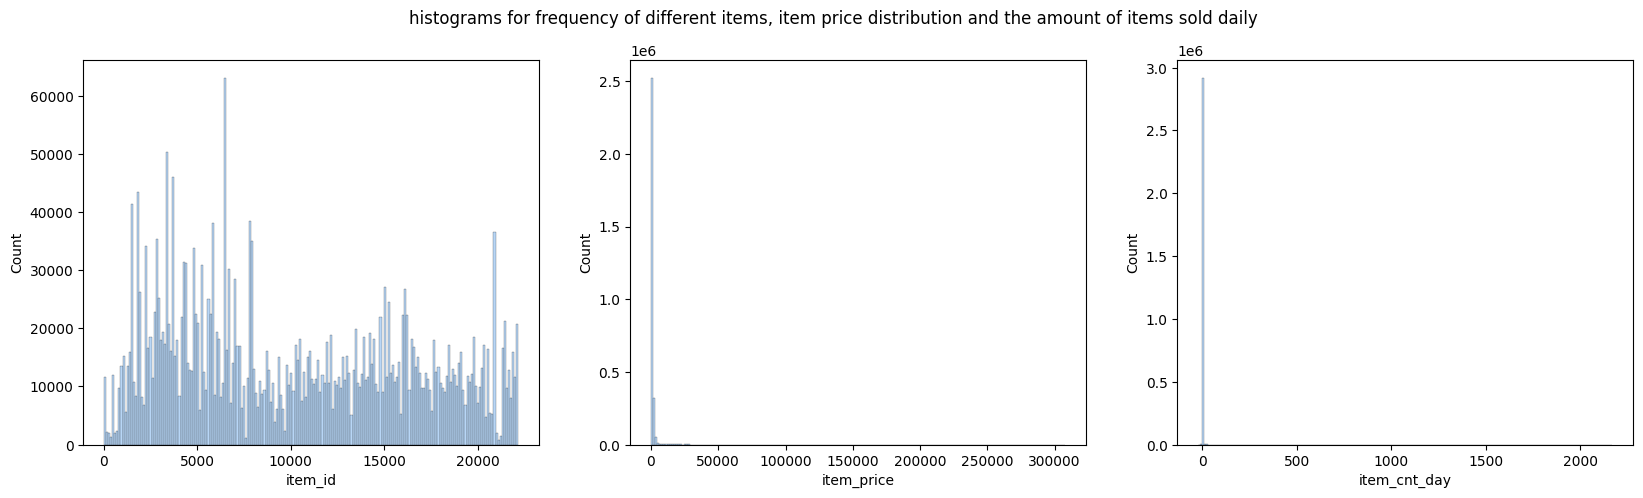

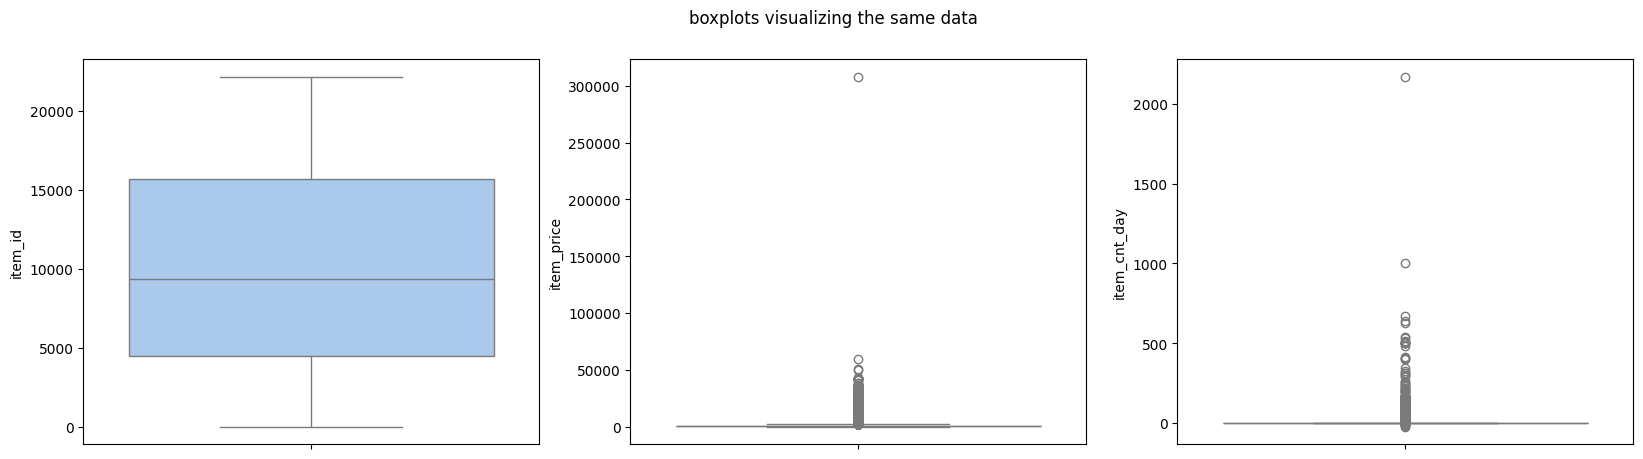

In [22]:
histplots(sales, num_cols, title="histograms for frequency of different items, item price distribution and the amount of items sold daily")
boxplots(sales, num_cols, title="boxplots visualizing the same data")

can see some distanced outliers in `item_price` and `item_cnt_day`, which have to be cleared later

#### checking for atypical spikes in sales

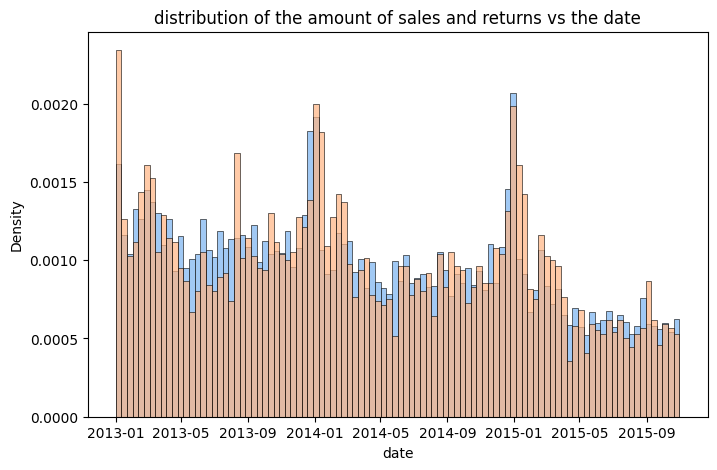

In [23]:
#using density as stat here so histograms have the same scale

plt.figure(figsize=(8, 5))
plt.title("distribution of the amount of sales and returns vs the date")
sns.histplot(sales['date'], bins=100, stat='density', alpha = 1)
sns.histplot(sales[sales['item_cnt_day'] < 0]['date'],
             bins=100, stat='density', alpha = 0.7)
plt.show()

both sales and returns spike around new year, which makes sense, so won't consider those spikes atypical

## checking which items form the outliers

In [24]:
mask = sales['item_cnt_day'] > 500
sales[mask].merge(items, on='item_id', how='inner')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2014-04-22,15,27,8057,1200.000000,502.0,iTunes 1500 руб.,32
1,2014-06-28,17,25,20949,5.000000,501.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71
2,2014-10-02,21,12,9242,1500.000000,512.0,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8
3,2014-10-09,21,55,19437,899.000000,508.0,"Средиземье: Тени Мордора [PC, Цифровая версия]",31
4,2015-01-15,24,12,20949,4.000000,1000.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71
5,2015-04-14,27,12,3731,1904.548077,624.0,"Grand Theft Auto V [PC, русские субтитры]",30
6,2015-05-19,28,12,11373,155.192950,539.0,Доставка до пункта выдачи (Boxberry),9
7,2015-09-29,32,55,9249,1500.000000,533.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8
8,2015-09-30,32,55,9249,1702.825746,637.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8
9,2015-09-30,32,12,9248,1692.526158,669.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80


the table above made me wanna check different types of tickets, because they look very similar. perhaps, they can be join into a single item type

In [25]:
with pd.option_context('display.max_colwidth', 400):
    display(items[items['item_name'].str.contains("Билет")])

,item_name,item_id,item_category_id
9240,"Билет ""День Бухгалтерии""",9240,73
9241,"Билет ""ИгроМир 2014"" (на один день (отдельно - 3 октября 2014))",9241,8
9242,"Билет ""ИгроМир 2014"" (на один день (отдельно - 4, 5 октября 2014))",9242,8
9243,"Билет ""ИгроМир 2014"" - семейный до 4-х человек вкл. (на один день (отдельно - 3, 4, 5 октября 2014))",9243,8
9244,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) [Цифровая версия]",9244,80
9245,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) УПР [Цифровая версия]",9245,8
9246,"Билет ""ИгроМир 2015"" - 2 октября 2015 [Цифровая версия]",9246,80
9247,"Билет ""ИгроМир 2015"" - 2 октября 2015 УПР [Цифровая версия]",9247,8
9248,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [Цифровая версия]",9248,80
9249,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) УПР [Цифровая версия]",9249,8


In [26]:
mask = sales['item_price'] > 50000
sales[mask].merge(items, on='item_id', how='inner')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2013-09-17,8,12,11365,59200.0,1.0,Доставка (EMS),9
1,2013-12-13,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75
2,2014-03-20,14,25,13199,50999.0,1.0,Коллекционные шахматы (Властелин Колец),69


checking items with most overall sales

In [27]:
items.merge(sales['item_id'].value_counts(), on='item_id', how='inner').sort_values('count', ascending=False)

,item_name,item_id,item_category_id,count
20602,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71,31340
5717,Playstation Store пополнение бумажника: Карта ...,5822,35,9408
17418,Прием денежных средств для 1С-Онлайн,17717,79,9067
2749,"Diablo III [PC, Jewel, русская версия]",2808,30,7479
4097,Kaspersky Internet Security Multi-Device Russi...,4181,75,6853
...,...,...,...,...
10551,ДВЕНАДЦАТЬ СТУЛЬЕВ (М.ЗАХАРОВ) (1-2 СЕРИЯ) (rem),10752,40,1
10552,ДВЕНАДЦАТЬ СТУЛЬЕВ (М.ЗАХАРОВ) (3-4 СЕРИЯ) (rem),10753,40,1
10597,ДЕВУШКА С ТАТУИРОВКОЙ ДРАКОНА,10799,40,1
10633,ДЕЛО ГАСТРОНОМА № 1,10835,40,1


## looking for a way to remove outliers

so, initially i was thinking of just using the z-score with a threshold, but then i decided to try a modified z-score as well because of its robustness to very distanced outliers (since it uses the median instead of mean)


#### defining the modified z-score and the function for actually removing the outliers

In [28]:
def modified_zscore(data : pd.Series):
    # probably there's an error in calculations somewhere, cause it literally equals infinity on some values
    median = data.median()
    mad = median_abs_deviation(data)
    if mad == 0:
        return pd.Series((data-median)/(1.253314*mad))
    return pd.Series((data-median)/(1.486*mad))

In [29]:
def remove_outliers(df : pd.DataFrame, column_names : list[str], criteria : callable = zscore, threshold : float = 3):
    for col in column_names:
        mask = abs(criteria(df[col])) > threshold
        df = df.drop(df[mask].index)
    return df

##### testing regular z-score

In [30]:
sales_copy = sales.copy()
before = sales_copy.shape[0]
sales_copy = remove_outliers(sales_copy, num_cols)
after = sales_copy.shape[0]

template = '{:2.2%} of data removed as outliers'

print(template.format(1 - (after/before)))

1.38% of data removed as outliers


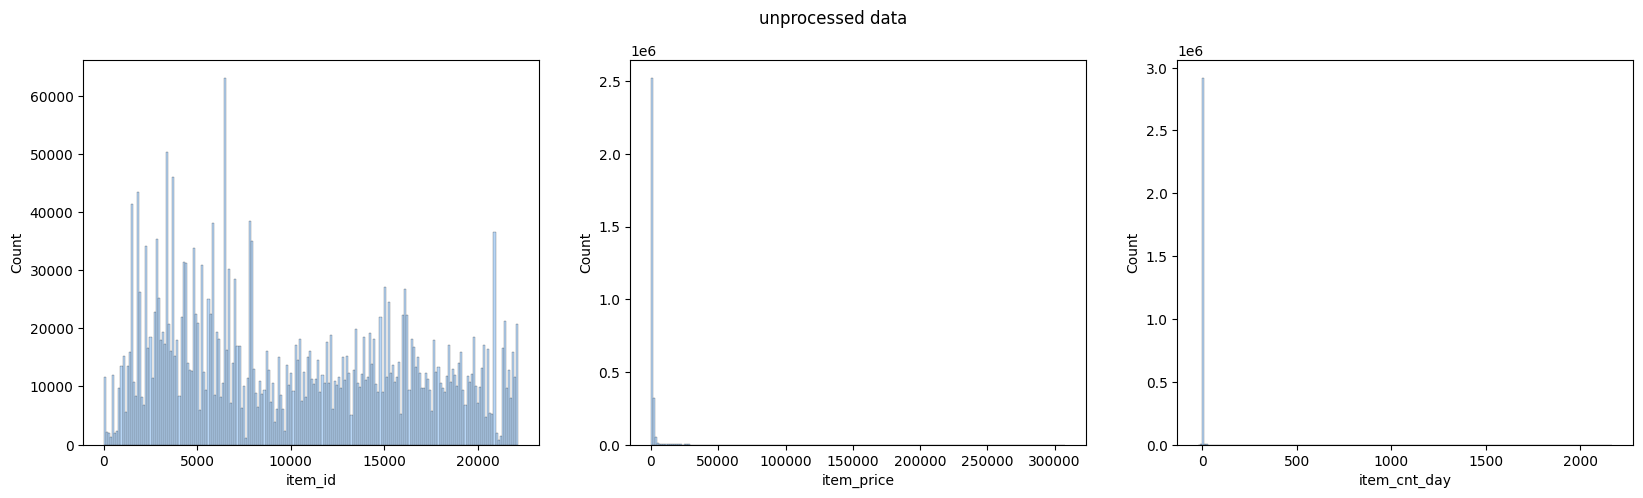

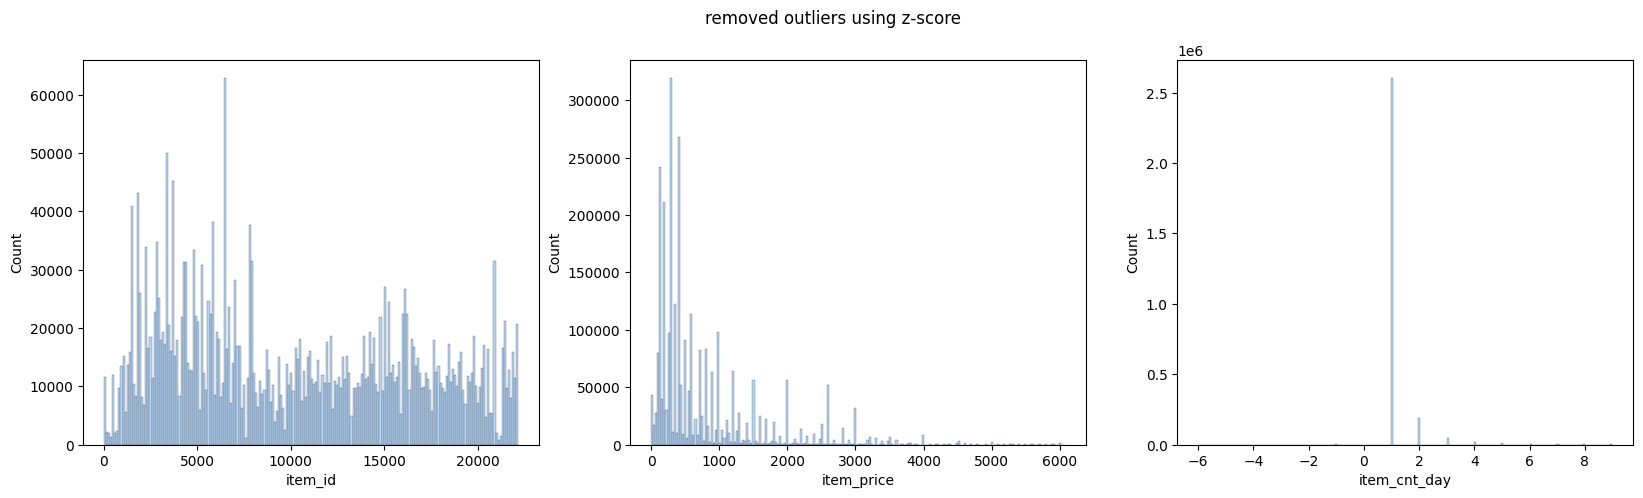

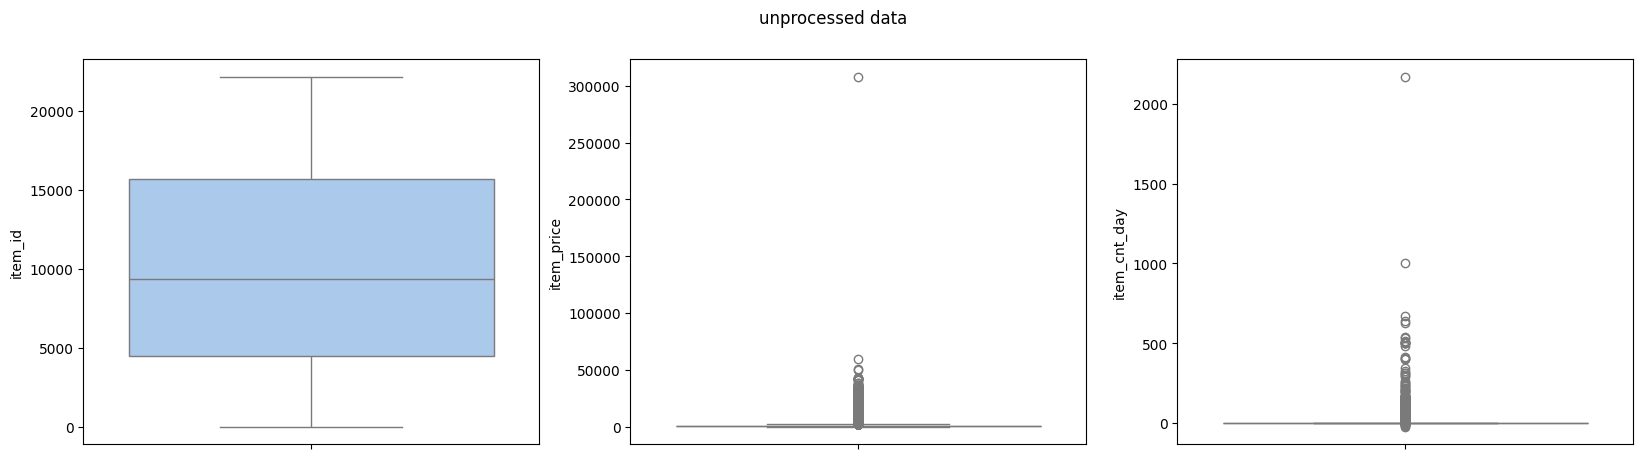

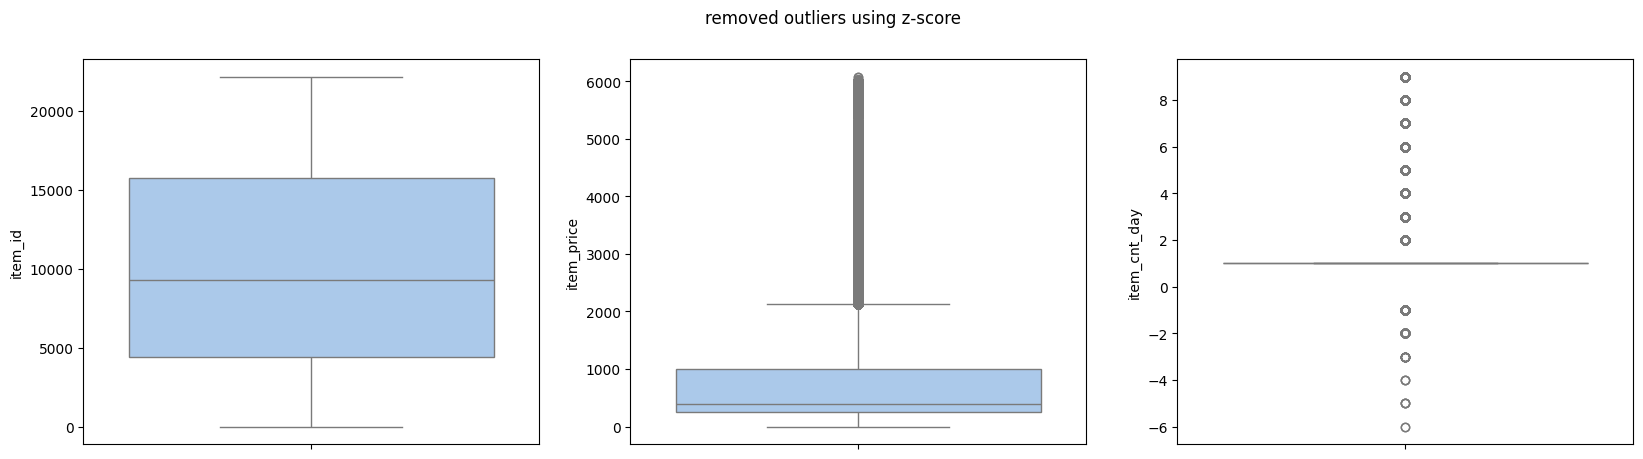

In [31]:
histplots(sales, num_cols, title="unprocessed data")
histplots(sales_copy, num_cols, title="removed outliers using z-score")
boxplots(sales, num_cols, title="unprocessed data")
boxplots(sales_copy, num_cols, title="removed outliers using z-score")

regular z-score performed decently well, removing very distanced values while still leaving some relatively frequent values for analysis. the `item_cnt_day` distribution still looks weird, but its probably case-specific, because most of the items are usually bought just a few times a day

#### modified z-score

In [32]:
sales_copy_mod = sales.copy()
before = sales_copy_mod.shape[0]
sales_copy_mod = remove_outliers(sales_copy_mod, num_cols, criteria=modified_zscore, threshold=5)
after = sales_copy_mod.shape[0]

template = '{:2.2%} of data removed as outliers'

print(template.format(1 - (after/before)))

17.33% of data removed as outliers


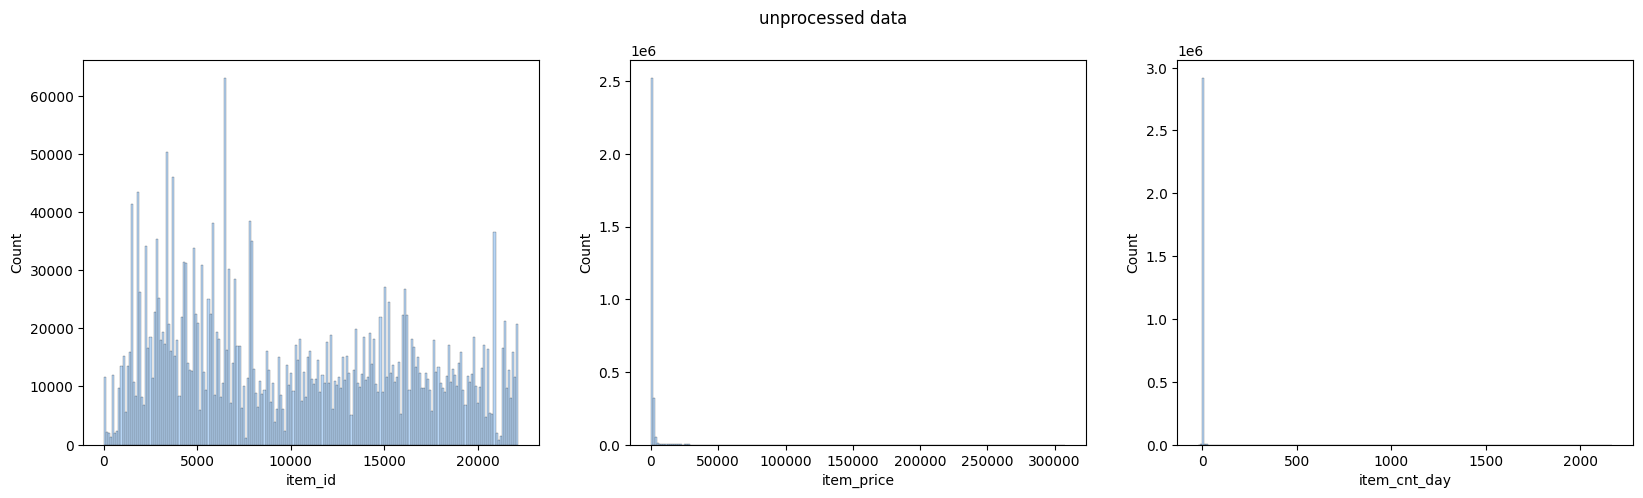

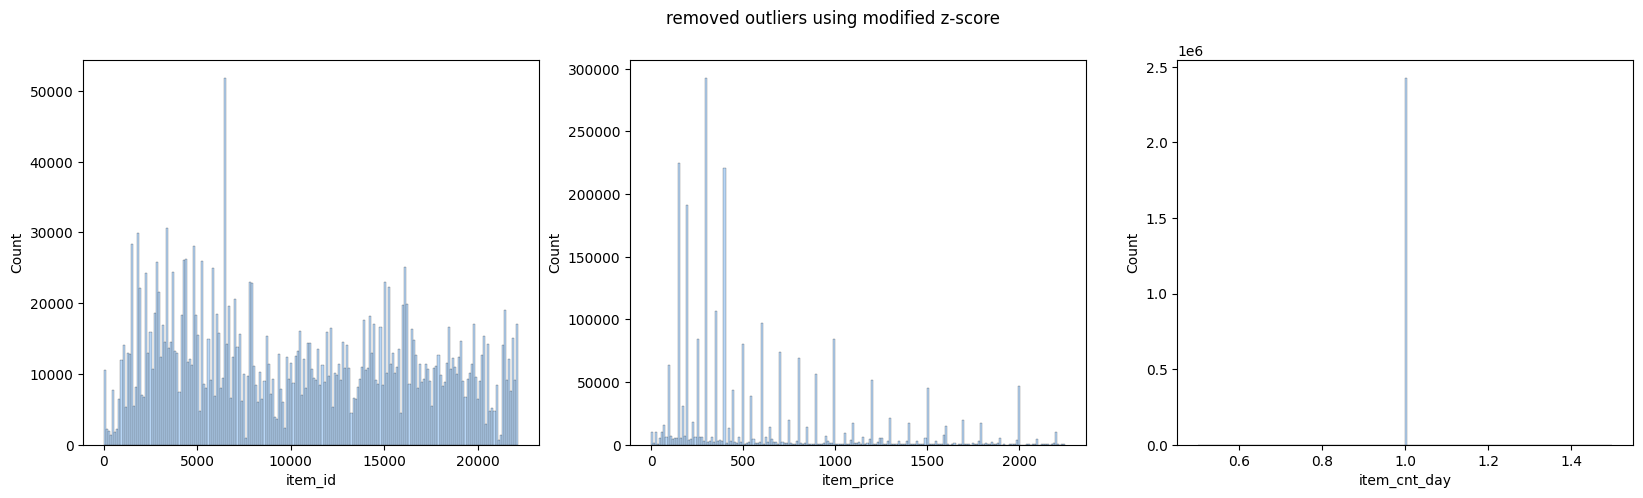

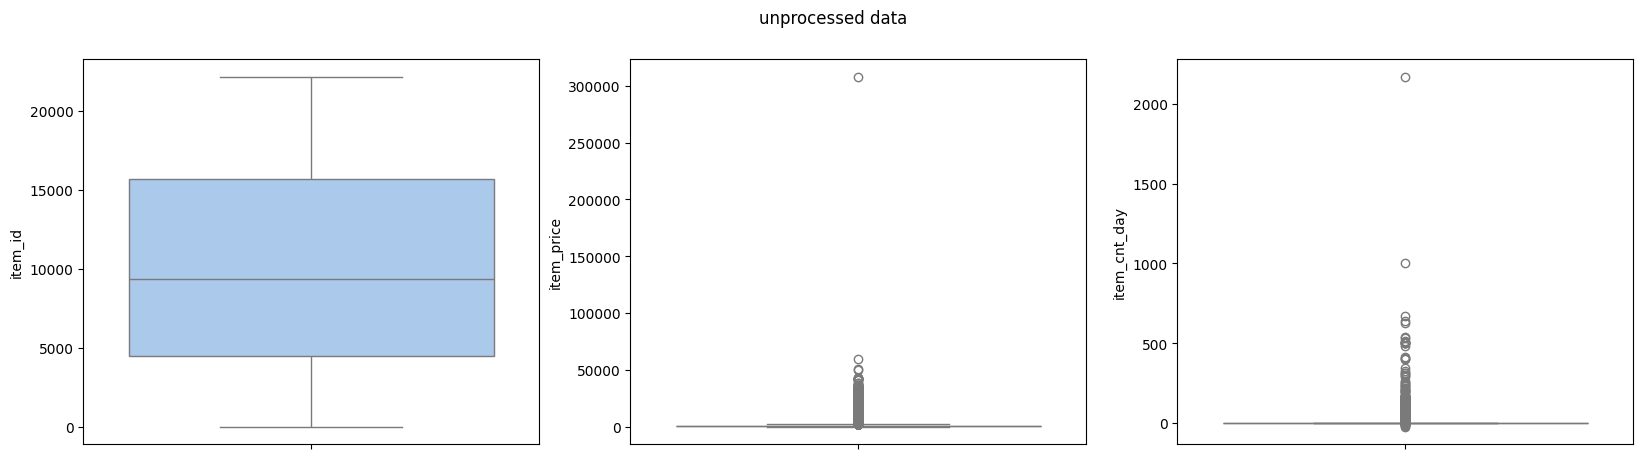

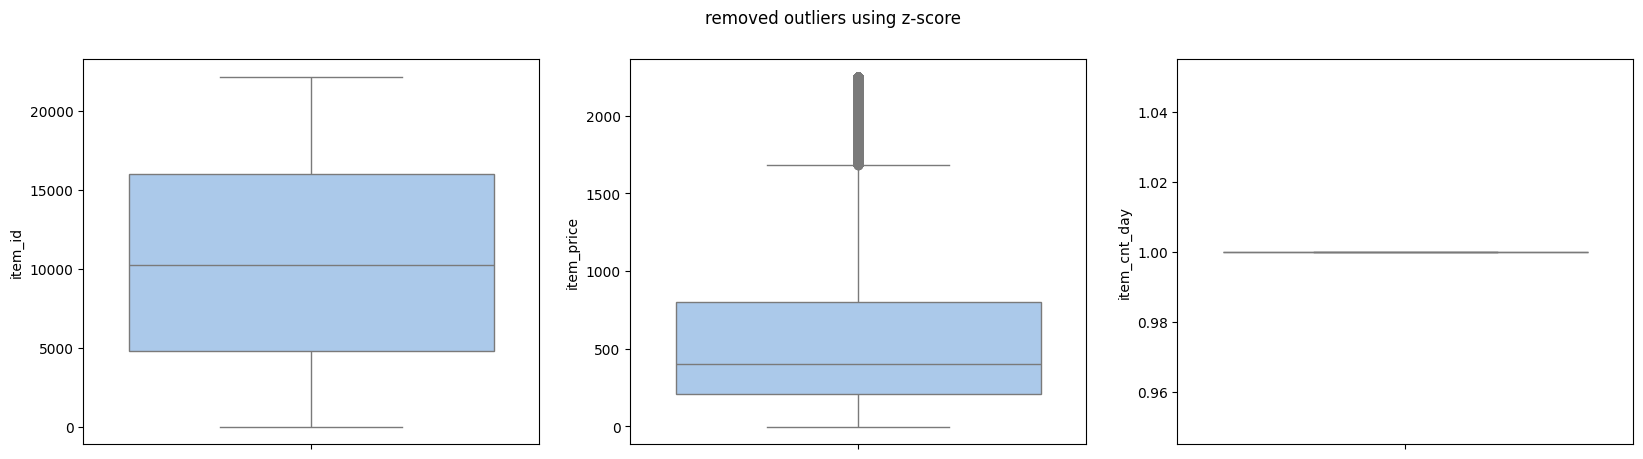

In [35]:
histplots(sales, num_cols, title="unprocessed data")
histplots(sales_copy_mod, num_cols, title="removed outliers using modified z-score")
boxplots(sales, num_cols, title="unprocessed data")
boxplots(sales_copy_mod, num_cols, title="removed outliers using z-score")

In [36]:
sales_copy_mod['item_cnt_day'].value_counts()

item_cnt_day
1.0    2427153
Name: count, dtype: int64

We lose too much data by using the modified z-score (probably due to my own mistake which I haven't found yet, but still), so we'll use the regular z-score for now. It also deletes all the values except `1`s from `item_cnt_day` which is very bad for us since we no longer can recieve information about the items that are returned or bought more frequently

## conclusion 


- Data does not contain unresolved references
- There are some outliers in data, which will have to be cleared 
- Different tables do not conflict with each other, however, in `items` and `shops` there are some duplicate values, references to which will have to be resolved later
- There's one item sold with negative price, so it should be removed
- Different kinds of tickets to the same event should *maybe* be merged into one
